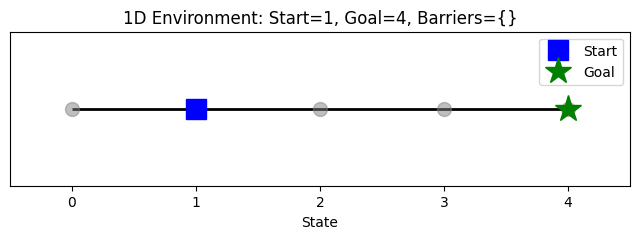

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

from utils.datasets import Dataset, GCDataset


class OneDEnv:
    def __init__(self, start, goal, barriers=None, stochasticity=0.0, n_states=5):
        self.start = start
        self.goal = goal
        self.barriers = barriers if barriers else {}
        self.stochasticity = stochasticity
        self.n_states = n_states
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        if self.state == self.goal:
            return self.state, 0, True  # Already at goal
        
        # Check if action is blocked by a barrier
        if self.state in self.barriers:
            if action == self.barriers[self.state]:
                return self.state, -1, False  # Invalid action
        
        # Apply stochasticity (action fails with probability `stochasticity`)
        if np.random.rand() < self.stochasticity:
            action = 1 - action  # Flip action
        
        # Compute new state
        new_state = self.state + (1 if action == 1 else -1)
        new_state = np.clip(new_state, 0, self.n_states - 1)
        
        # Reward: +1 for reaching the goal, -1 for invalid action, 0 otherwise
        reward = 1 if new_state == self.goal else (-1 if self.state == new_state and action in self.barriers.get(self.state, []) else 0)
        done = new_state == self.goal
        
        self.state = new_state
        return new_state, reward, done

# --------------------------
# Dataset Generation
# --------------------------
def generate_random_layout(n_states=5, make_stochastic: bool = False):
    start = np.random.randint(0, n_states)
    goal = start
    while goal == start:
        goal = np.random.randint(0, n_states)
    barriers = {}
    if np.random.rand() < 0.3:  # 30% chance of adding a barrier
        barrier_state = np.random.randint(0, n_states)
        blocked_action = np.random.randint(0, 2)  # 0 (left) or 1 (right)
        barriers[barrier_state] = blocked_action
    if make_stochastic:
        stochasticity = np.random.choice([0.0, 0.1, 0.2])
    else:
        stochasticity = 0.0
    return {
        'start': start,
        'goal': goal,
        'barriers': barriers,
        'stochasticity': stochasticity,
        'n_states': n_states
    }

def collect_trajectory(env, max_steps=5):
    trajectory = []
    state = env.reset()
    done = False
    for _ in range(max_steps):
        if done:
            break
        action = np.random.randint(0, 2)  # Random action (0=left, 1=right)
        next_state, _, done = env.step(action)
        trajectory.append((state, action, next_state))
        state = next_state
    return trajectory

def plot_1d_env(start, goal, barriers=None, n_states=5):
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.hlines(0, 0, n_states-1, colors='k', lw=2)
    ax.set_xlim(-0.5, n_states-0.5)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.set_xticks(range(n_states))
    ax.set_xlabel("State")
    # Plot states
    for s in range(n_states):
        ax.plot(s, 0, 'o', markersize=10, color='gray', alpha=0.5)
    # Start and goal
    ax.plot(start, 0, 's', markersize=15, color='blue', label='Start')
    ax.plot(goal, 0, '*', markersize=20, color='green', label='Goal')
    # Barriers
    if barriers:
        for s, a in barriers.items():
            action = "←" if a == 0 else "→"
            ax.text(s, 0.2, f"Block {action}", ha='center', va='bottom', color='red')
    ax.legend()
    plt.title(f"1D Environment: Start={start}, Goal={goal}, Barriers={barriers}")
    plt.show()
    
layout = generate_random_layout(n_states=5, make_stochastic=True)
plot_1d_env(layout['start'], layout['goal'], layout['barriers'])
# dataset = TransitionDataset(n_layouts=1000, seq_len=10, n_states=5)

In [2]:
from tqdm.auto import tqdm
import functools
import jax
import jax.numpy as jnp

def random_exploration(num_steps):
    dataset = dict()
    observations = []
    actions = []
    dones = []
    barriers = []
    barriers_type = []
    
    for _ in range(1):
        layout = generate_random_layout(n_states=5, make_stochastic=False)
        env = OneDEnv(**layout)
        state = env.reset()
        cur_observations, cur_actions, cur_dones = [], [], []
        cur_barriers, cur_barrier_type = [], []
        
        for _ in range(num_steps):
            cur_observations.append(np.array(state, dtype=np.float32))
            cur_barriers.append(-1)
            cur_barrier_type.append(-1)
            action = np.random.randint(0, 2)
            next_state, _, done = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        barriers.append(np.stack(cur_barriers))
        barriers_type.append(np.stack(cur_barrier_type))

    # Concatenate all episodes
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    dataset['barriers'] = np.concatenate(barriers)
    dataset['barrier_type'] = np.concatenate(barriers_type)
    
    # Mask out terminal states
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    for key in ['observations', 'actions', 'terminals', 'barriers', 'barrier_type']:
        dataset[key] = dataset[key][ob_mask]
    
    # Generate next_observations and align lengths
    dataset['next_observations'] = dataset['observations'][1:]  # Shift to get next states
    for key in ['observations', 'actions', 'terminals', 'barriers', 'barrier_type']:
        dataset[key] = dataset[key][:-1]  # Truncate to match next_observations
    
    return dataset

train_layout_data = []

for i in tqdm(range(5)):
    dataset_random = random_exploration(5)
    train_layout_data.append(dataset_random)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)

  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
whole_dataset = Dataset.create(**jax.device_get(whole_data))
whole_dataset.sample(1)

{'actions': array([0.], dtype=float32),
 'barrier_type': array([-1], dtype=int32),
 'barriers': array([-1], dtype=int32),
 'next_observations': array([3.], dtype=float32),
 'observations': array([4.], dtype=float32),
 'terminals': array([0.], dtype=float32)}

In [35]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def create_ground_truth_embedding(layout, n_states=5):
    """Convert MDP parameters into a ground truth embedding vector."""
    start = layout['start']
    goal = layout['goal']
    barriers = layout['barriers']
    stochasticity = layout['stochasticity']
    
    # One-hot encode start and goal
    start_enc = np.zeros(n_states)
    start_enc[start] = 1
    goal_enc = np.zeros(n_states)
    goal_enc[goal] = 1
    
    # Encode barriers (left/right blocked per state)
    left_blocked = np.zeros(n_states)
    right_blocked = np.zeros(n_states)
    for state, action in barriers.items():
        if action == 0:
            left_blocked[state] = 1
        elif action == 1:
            right_blocked[state] = 1
    
    # Scale stochasticity to [0, 1]
    stochasticity_scaled = stochasticity / 0.2  # assuming max stochasticity=0.2
    
    # Concatenate all components
    embedding = np.concatenate([
        start_enc,
        goal_enc,
        left_blocked,
        right_blocked,
        [stochasticity_scaled]
    ])
    return embedding

def generate_layouts(n_layouts=5, n_states=6):
    """Generate MDP layouts and compute ground truth embeddings."""
    layouts = []
    embeddings = []
    for _ in range(n_layouts):
        layout = generate_random_layout(n_states, make_stochastic=True)
        embedding = create_ground_truth_embedding(layout, n_states)
        layouts.append(layout)
        embeddings.append(embedding)
    return np.array(embeddings), layouts

# Generate 200 layouts and their embeddings
gt_embeddings, layouts = generate_layouts(n_layouts=200)

In [36]:
def reduce_dimensions(embeddings, method='pca'):
    """Reduce embeddings to 2D for visualization."""
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Use 'pca' or 'tsne'.")
    return reducer.fit_transform(embeddings)

# Reduce to 2D
pca_results = reduce_dimensions(gt_embeddings, method='pca')
tsne_results = reduce_dimensions(gt_embeddings, method='tsne')

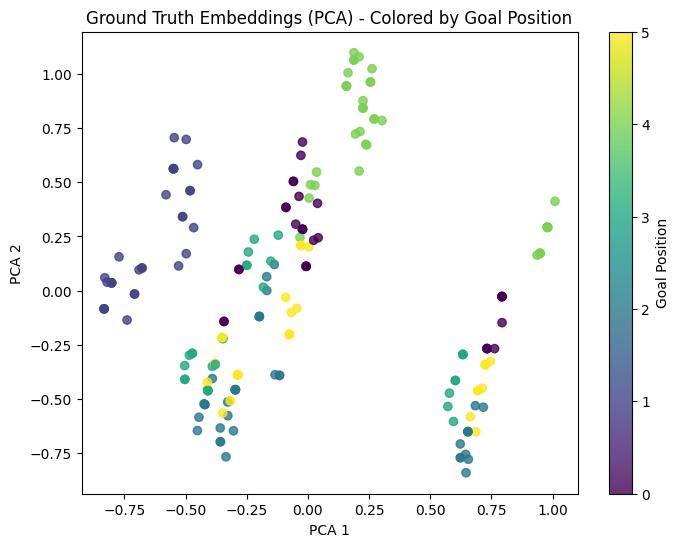

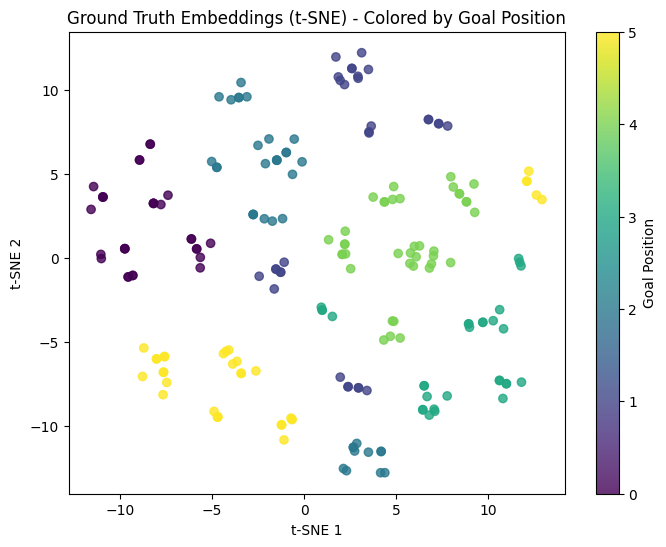

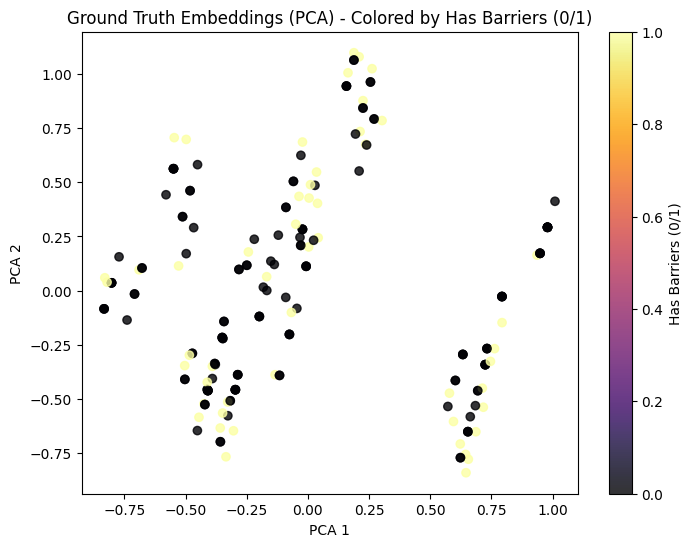

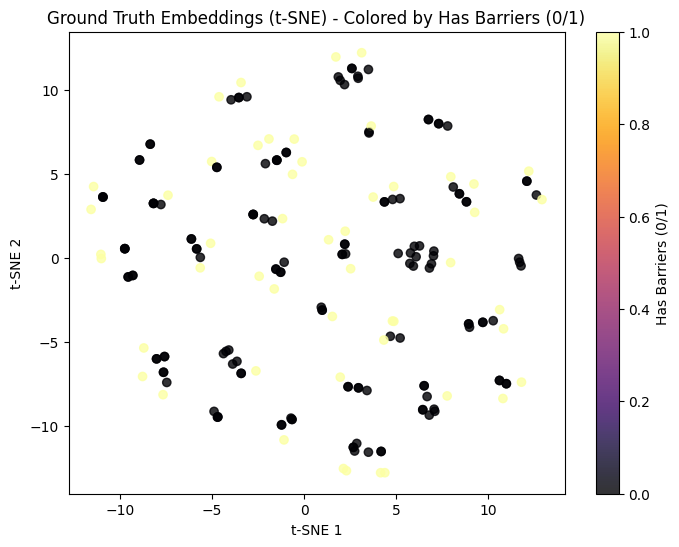

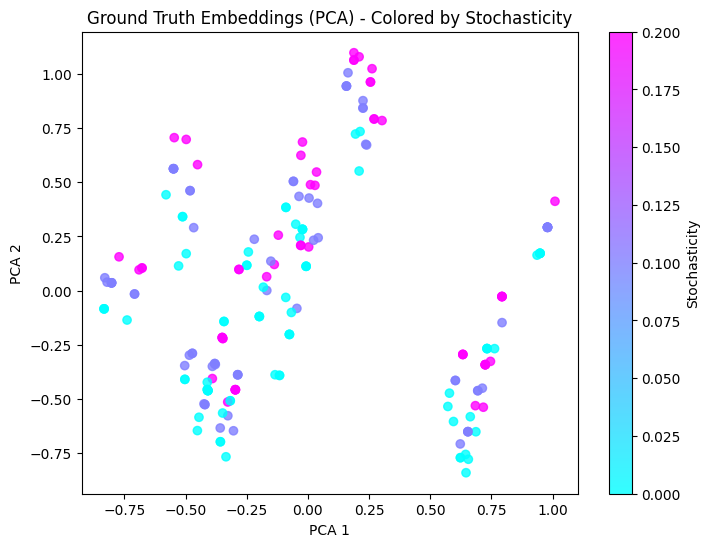

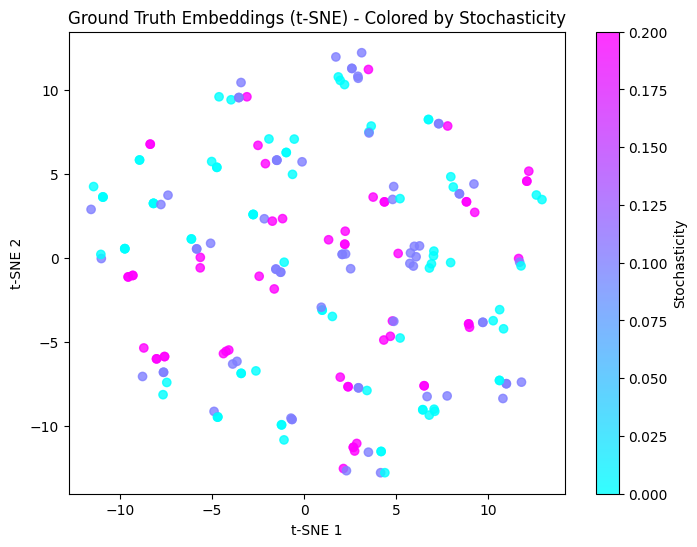

In [37]:
def plot_embeddings(results, layouts, color_property='goal', title=''):
    """Plot 2D embeddings colored by a property."""
    plt.figure(figsize=(8, 6))
    if color_property == 'goal':
        colors = [layout['goal'] for layout in layouts]
        cmap = 'viridis'
        label = 'Goal Position'
    elif color_property == 'start':
        colors = [layout['start'] for layout in layouts]
        cmap = 'plasma'
        label = 'Start Position'
    elif color_property == 'barriers':
        colors = [len(layout['barriers']) > 0 for layout in layouts]
        cmap = 'inferno'
        label = 'Has Barriers (0/1)'
    elif color_property == 'stochasticity':
        colors = [layout['stochasticity'] for layout in layouts]
        cmap = 'cool'
        label = 'Stochasticity'
    
    scatter = plt.scatter(results[:, 0], results[:, 1], c=colors, cmap=cmap, alpha=0.8)
    plt.colorbar(scatter, label=label)
    plt.xlabel(f'{title} 1')
    plt.ylabel(f'{title} 2')
    plt.title(f'Ground Truth Embeddings ({title}) - Colored by {label}')
    plt.show()

# Plot PCA and t-SNE for different properties
plot_embeddings(pca_results, layouts, color_property='goal', title='PCA')
plot_embeddings(tsne_results, layouts, color_property='goal', title='t-SNE')

plot_embeddings(pca_results, layouts, color_property='barriers', title='PCA')
plot_embeddings(tsne_results, layouts, color_property='barriers', title='t-SNE')

plot_embeddings(pca_results, layouts, color_property='stochasticity', title='PCA')
plot_embeddings(tsne_results, layouts, color_property='stochasticity', title='t-SNE')

In [38]:
from utils.datasets import GCDataset
import sys
sys.path.append("..")
from pprint import pprint
from agents.fb import ForwardBackwardAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=discrete.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], 1),
    config=fb_config['agent']
)
# fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

{'agent': {'actor_geom_sample': False,
           'actor_p_curgoal': 0.0,
           'actor_p_randomgoal': 1.0,
           'actor_p_trajgoal': 0.0,
           'agent_name': 'fb',
           'b_hidden_dims': [512, 512, 512],
           'b_layer_norm': True,
           'batch_size': 1024,
           'boltzmann': True,
           'clip_by_global_norm': True,
           'dataset_class': 'GCDataset',
           'discount': 0.99,
           'discrete': True,
           'f_hidden_dims': [512, 512, 512],
           'f_layer_norm': True,
           'frame_stack': None,
           'gc_negative': True,
           'lr': 0.0003,
           'p_aug': 0.0,
           'tau': 0.01,
           'value_geom_sample': True,
           'value_p_curgoal': 0.0,
           'value_p_randomgoal': 0.0,
           'value_p_trajgoal': 1.0,
           'z_dim': 150,
           'z_mix_ratio': 0.5},
 'env': {'discrete': True, 'env_name': 'gridworld'},
 'eval_episodes': 1,
 'eval_gaussian': None,
 'eval_interval': 200000,

IndexError: index -1 is out of bounds for axis 0 with size 0